In [1]:
#this is where single run functions such as creating the flat pickle file(flat database) and loading aligning spectra
%load_ext autoreload
%autoreload

from pipeline import import_aligning_spectra
from NRES_SHK_Pipeline import create_flat_dict_file
#from matplotlib.backends.backend_pdf import PdfPages
import NRES_SHK_Pipeline as nresshk
import pipeline_testing as t
import helpers as h

#Soon to be settings.xml
#Project folder directory on your computer
homePath = 'D:/My Documents/Coding Projects/nreshk/'

#required paths for pipeline, try not to change ever
dataPath = homePath + 'data/'
outputPath = homePath + 'output/'
flatPath = dataPath + 'flats/'
flatPickle = "flatDict.pkl"

create_flat_dict_file(flatPath,flatPickle)

#need this in memory for the following wrapper
#TODO maybe a better way to do this without lugging the lab spectra around every install
lab = import_aligning_spectra(dataPath+ 'LabSpectra/', resolution=0)#,res*10)

flatDict = nresshk.NRES_SHK_MkFlat(flatPath,flatPickle)

print('done')

done


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
100180 is not in force run
114710 is not in force run
115383 is not in force run
115404 is not in force run
120136 is not in force run
12235 is not in force run
126053 is not in force run
136202 is not in force run
149661 is not in force run
152391 is not in force run
154417 is not in force run
165341A is not in force run
17051 is not in force run
176051 is not in force run
182101 is not in force run
1835 is not in force run
187691 is not in force run
190406 is not in force run
194012 is not in force run
20630 is not in force run
206860 is not in force run
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 22049
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Number of observations: 53
-------------------------------------------------------------------------------
MJD: 58354.3656538 and decYr 2018.6448374076713 with 67

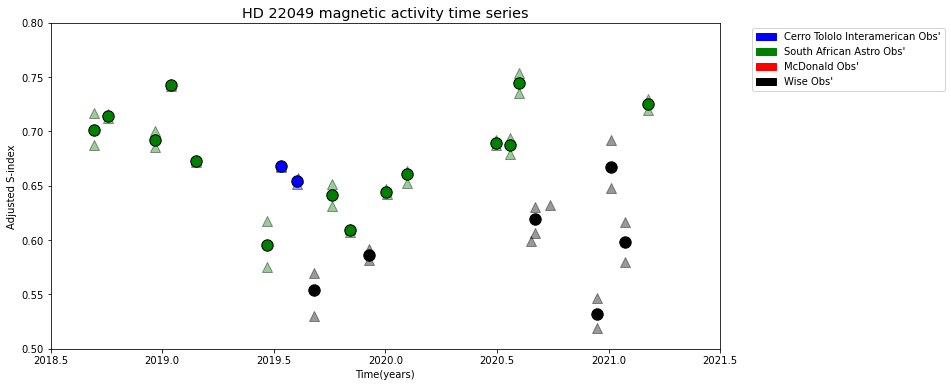

26913 is not in force run
30495 is not in force run
37394 is not in force run
43587 is not in force run
49933 is not in force run
75332 is not in force run
76151 is not in force run
78366 is not in force run
82443 is not in force run
82885 is not in force run
88737 is not in force run
98230B is not in force run
bad folder 'flats'
bad folder 'LabSpectra'
bad folder 'new68_22049'
bad folder 'old_22049'
bad folder 'old_flat'
bad folder 'replaced67order'


In [2]:
%load_ext autoreload
%autoreload

#normal run start up

#MJD dates known to be bad TODO better feature use, maybe not w/ mjd
skip = []#should be empty list if not skipping any
#skip = [58088.0763592, 58088.0801385, 58162.0245788, 58162.028358, 58272.4211262, 58272.4248934, 58354.2323109, 58354.2381758, 58553.7479017, 58553.7527935, 58821.1965842, 58821.2014756]



#a list of stars we MUST run, regardless of if there is already output
#it will not run any other star if this is None
forceRun = ["22049"]#["152391"]#,["100180"]
#forceRun = None  


#manualAdj is for observations which are not being offset properly. combine with 'only' functionality to tweek the adjustment
#this is not really desirable but we'd rather have correct offsets than not and if automatic not working oh well

#window order taken from helpers.analyzedData offsets 9/10/20 Ca H, Ca K, R band, B band
#manAdj = [[58045.1409353],
        #[[-.04,-.04,-.0555,-.044]

        #]]
manAdj = None


#debug mode only has on or off at the moment and will cause lots of printing. Not really implemented and should not be trusted
h.debug = False


#output mode
#0 - all output 
#1 - only final time series pdf's created
#2 - only star N/A
#etc
h.pdfMode = 0


#for testing ONLY specific obs should be None if not testing specific mjd

#None#[58850,58821,58791,58791]
only=None

#TODO impement|
#if using radial velocity to align must have dict of star HD's and their rv"
alignmentDict = []#currently N/A"

#t.test_daily_data_sum()

analyzedData = nresshk.NRES_SHK_Pipeline(dataPath,outputPath,flatDict,lab,skip,forceRun,manAdj,only)




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
100180 is not in force run
114710 is not in force run
115383 is not in force run
115404 is not in force run
120136 is not in force run
12235 is not in force run
126053 is not in force run
136202 is not in force run
149661 is not in force run
152391 is not in force run
154417 is not in force run
165341A is not in force run
17051 is not in force run
176051 is not in force run
182101 is not in force run
1835 is not in force run
187691 is not in force run
190406 is not in force run
194012 is not in force run
20630 is not in force run
206860 is not in force run
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 22049
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Number of observations: 58
-------------------------------------------------------------------------------
MJD: 58761.9901174 and decYr 2019.76161676 with 67 orde

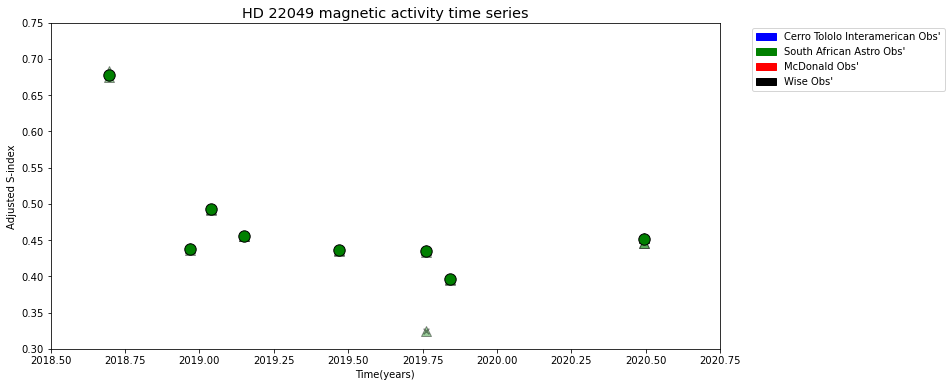

26913 is not in force run
30495 is not in force run
37394 is not in force run
43587 is not in force run
49933 is not in force run
75332 is not in force run
76151 is not in force run
78366 is not in force run
82443 is not in force run
82885 is not in force run
88737 is not in force run
98230B is not in force run
bad folder 'flats'
bad folder 'LabSpectra'
bad folder 'old_22049'
bad folder 'old_flat'
bad folder 'old_output'
bad folder 'replaced67order'


In [5]:
%load_ext autoreload
%autoreload

import helpers as h
h.pdfMode = 0
h.conWid= 2/2
manAdj = None
forceRun = ["22049"]
skip = []#
only=[58761,58372,58471,58497,58538,58655,58791,59030]



outputPath = homePath + 'output/'+'20ang_oldnew'
analyzedData = nresshk.NRES_SHK_Pipeline(dataPath,outputPath,flatDict,lab,skip,forceRun,manAdj,only,None)

In [3]:
%load_ext autoreload
%autoreload
#testing band pass data gatehering
import helpers as h
h.pdfMode = 0
h.conWid= 2/2
forceRun = ["22049"]
manAdj=None
skip = []#
only=[58761,58372,58471,58497,58538,58655,58791,59030]


outputPath = homePath + 'output/'+'20ang_oldnew'
analyzedData = nresshk.NRES_SHK_Pipeline(dataPath,outputPath,flatDict,lab,skip,forceRun,manAdj,only,None)
outputPath = homePath + 'output/'+'20ang_newnew'
analyzedData = nresshk.NRES_SHK_Pipeline(dataPath,outputPath,flatDict,lab,skip,forceRun,manAdj,only,67)
analyzedData = nresshk.NRES_SHK_Pipeline(dataPath,outputPath,flatDict,lab,skip,forceRun,manAdj,only,68)

h.conWid= 1.5/2
outputPath = homePath + 'output/'+'15ang_oldnew'
analyzedData = nresshk.NRES_SHK_Pipeline(dataPath,outputPath,flatDict,lab,skip,forceRun,manAdj,only,None)
outputPath = homePath + 'output/'+'15ang_newnew'
analyzedData = nresshk.NRES_SHK_Pipeline(dataPath,outputPath,flatDict,lab,skip,forceRun,manAdj,only,67)
analyzedData = nresshk.NRES_SHK_Pipeline(dataPath,outputPath,flatDict,lab,skip,forceRun,manAdj,only,68)

h.conWid= 1/2
outputPath = homePath + 'output/'+'10ang_oldnew'
analyzedData = nresshk.NRES_SHK_Pipeline(dataPath,outputPath,flatDict,lab,skip,forceRun,manAdj,only,None)
outputPath = homePath + 'output/'+'10ang_newnew'
analyzedData = nresshk.NRES_SHK_Pipeline(dataPath,outputPath,flatDict,lab,skip,forceRun,manAdj,only,67)
analyzedData = nresshk.NRES_SHK_Pipeline(dataPath,outputPath,flatDict,lab,skip,forceRun,manAdj,only,68)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
100180 is not in force run
114710 is not in force run
115383 is not in force run
115404 is not in force run
120136 is not in force run
12235 is not in force run
126053 is not in force run
136202 is not in force run
149661 is not in force run
152391 is not in force run
154417 is not in force run
165341A is not in force run
17051 is not in force run
176051 is not in force run
182101 is not in force run
1835 is not in force run
187691 is not in force run
190406 is not in force run
194012 is not in force run
20630 is not in force run
206860 is not in force run
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 22049
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Number of observations: 76
-------------------------------------------------------------------------------
MJD: 58372.9628576 and decYr 2018.695788650959 with 67 